In [1]:
# Install required packages
!pip install tensorflow scikit-learn matplotlib seaborn

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Define paths to your datasets
train_dir = '/kaggle/input/undersample-majority/undersample_split/1.train'
val_dir = '/kaggle/input/undersample-majority/undersample_split/2.val'
test_dir = '/kaggle/input/undersample-majority/undersample_split/3.test'

In [3]:
# Data normalization
datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 467 images belonging to 7 classes.
Found 100 images belonging to 7 classes.
Found 101 images belonging to 7 classes.


In [4]:
# Number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [5]:
# Define the ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [10]:
# Train the model with early stopping
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=15,  # Set a higher number of epochs, early stopping will handle it
    callbacks=[early_stopping]
)
training_time = time.time() - start_time

print(f"Training time: {training_time:.2f} seconds")

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.1505 - loss: 1.9350 - val_accuracy: 0.1667 - val_loss: 1.9326
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2632 - loss: 1.9027 - val_accuracy: 0.5000 - val_loss: 1.9504
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 815ms/step - accuracy: 0.1694 - loss: 1.9385 - val_accuracy: 0.1979 - val_loss: 1.9316
Training time: 45.69 seconds


In [11]:
# Evaluate the model
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.labels # Remove np.argmax here

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


In [12]:

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=list(train_generator.class_indices.keys()))
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.1584
Classification Report:
                          precision    recall  f1-score   support

         1. No DR signs       0.00      0.00      0.00        15
2. Mild (or early) NPDR       0.18      1.00      0.30        15
       3. Moderate NPDR       0.00      0.00      0.00        12
         4. Severe NPDR       0.00      0.00      0.00        15
    5. Very Severe NPDR       0.06      0.07      0.06        15
                 6. PDR       0.00      0.00      0.00        14
        7. Advanced PDR       0.00      0.00      0.00        15

               accuracy                           0.16       101
              macro avg       0.03      0.15      0.05       101
           weighted avg       0.04      0.16      0.05       101



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


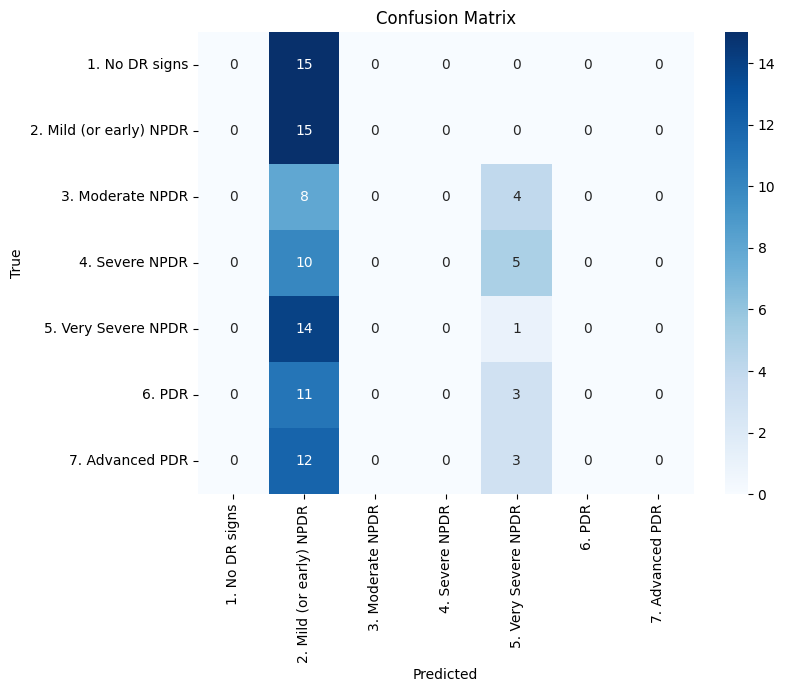

In [13]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()